In [46]:
from LOTlib.DataAndObjects import FunctionData, Obj
from LOTlib.DefaultGrammars import DNF
from LOTlib.Miscellaneous import q
from LOTlib.Hypotheses.LOTHypothesis import LOTHypothesis
from LOTlib.Hypotheses.Priors.RationalRules import RationaRulesPrior
from LOTlib.Hypotheses.Likelihoods.BinaryLikelihood import BinaryLikelihood
from LOTlib.Inference.Samplers.StandardSample import standard_sample
from LOTlib.Inference.Samplers.MetropolisHastings import MHSampler
from LOTlib.TopN import TopN
from LOTlib.Miscellaneous import logsumexp 
from numpy import exp # but things that are handy in numpy are not duplicated (usually)
import numpy as np
from ipyparallel import Client
import pandas as pd
import os.path as op
import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
rc = Client()

# Get the data into a nice format

In [32]:
data = pd.read_csv('./AllData.csv')

#make features explicit
features = ["green",'yellow','red','square','circle','triangle','grid','dot','wave']
feature_map = {x:f for x,f in enumerate(features)}

stims = ['stim11','stim12','stim13','stim21','stim22','stim23','stim31','stim32','stim33']
for s in stims:
    data[s] = [feature_map[int(x)-1] for x in data[s]]


#clean data    
clean_data = data[['subj','trial','gameNumber','choice','outcome']]
for i in map(str,range(1,4)):
    clean_data.loc[:,'stim' + i] = ['_'.join([x,y,z]) for x,y,z in zip(data['stim' + i + '1'],
                                                      data['stim' + i + '2'],
                                                      data['stim' + i + '3'])]

#make chosen stim explicit
clean_data = clean_data.dropna()
for index, row in clean_data.iterrows():
    clean_data.loc[index,'chosen_stim'] = row['stim' + str(int(row['choice']))]

data = clean_data

In [33]:
data = data.set_index(['subj','gameNumber'])

In [34]:
for x in list(set(data.index)):
    ntrials = data.loc[x].shape[0]
    data.loc[x,'trial'] = range(ntrials)

In [35]:
#function to map from dataframes to objects required by LOTlib
def make_function(stim, outcome, alpha = .999):
    features = stim.split('_')
    func = FunctionData(input=[Obj(color = features[0],
                            shape = features[1],
                            pattern = features[2])], output = outcome, alpha=alpha)
    return func

# Define Grammar

In [5]:
#only run this once!
# DNF defaultly includes the logical connectives so we need to add predicates to it.
grammar = DNF

# Two predicates for checking x's color and shape
# Note: per style, functions in the LOT end in _
grammar.add_rule('PREDICATE', 'is_color_', ['x', 'COLOR'], 1.0)
grammar.add_rule('PREDICATE', 'is_shape_', ['x', 'SHAPE'], 1.0)
grammar.add_rule('PREDICATE', 'is_pattern_', ['x', 'PATTERN'], 1.0)

# These are written in quotes so they can be evaled
grammar.add_rule('COLOR', q('red'), None, 1.0)
grammar.add_rule('COLOR', q('yellow'), None, 1.0)
grammar.add_rule('COLOR', q('green'), None, 1.0)

grammar.add_rule('SHAPE', q('square'), None, 1.0)
grammar.add_rule('SHAPE', q('circle'), None, 1.0)
grammar.add_rule('SHAPE', q('triangle'), None, 1.0)


grammar.add_rule('PATTERN', q('grid'), None, 1.0)
grammar.add_rule('PATTERN', q('dot'), None, 1.0)
grammar.add_rule('PATTERN', q('wave'), None, 1.0)


PATTERN -> 'wave'	w/ p=1.0

# Apply Rational Rules to each subject's sequence of evidence and record the posterior predictive for all stimuli on each trial

In [6]:
def get_data(sub,run):
    
    block_data = []
    option_data = []
    alpha = .75
    for x in data.loc[(sub,run)].iterrows():
        #chosen stimulus used for inference
        choice = x[1]['chosen_stim']
        outcome = bool(x[1]['outcome'])
        block_data.append(make_function(choice, outcome, alpha))

        #all stimuli used for evaluation
        choice1 = x[1]['stim1']
        choice2 = x[1]['stim2']
        choice3 = x[1]['stim3']
        option_data.append([make_function(choice1, False, alpha),
                           make_function(choice2, False, alpha),
                           make_function(choice3, False, alpha)])
        
    return block_data, option_data

In [7]:
def run_inference(grammar, block_data):
    # run inference on various amounts of data
    initial_hyp = LOTHypothesis(grammar, start='START', ALPHA=.99, maxnodes=20)

    samples = 10000
    TOP = 100
    H = TopN()  # Across everything

    for i in xrange(len(block_data)): 
        hyps = TopN(N=TOP)
        for h in MHSampler(initial_hyp, block_data[:i], samples, skip=0):
            if h.posterior_score > -float("inf"):  # Otherwise KL gets messed up!
                hyps.add(h, h.posterior_score)

        # save these to our finite list
        H.update(hyps)
        
    return H

In [8]:
def compute_predictive(H, block_data, option_data):
    hypotheses = [h for h in H.get_all()]  # make a list, fixed order


    trial_posterior_predictive = []
    for i in xrange(len(option_data)):
        posteriors, predictive = [], []
        for h in hypotheses:
            posteriors.append(h.compute_posterior(block_data[:i])) #compute from chosen stimuli

            #store each rules' prediction
            option_predictives = []
            for option in option_data[i]:
                option_predictives.append(h(*option.input))
            predictive.append(option_predictives)

        #normalize posteriors    
        Z = logsumexp(posteriors)
        posteriors = np.array(posteriors) - Z  # normalize posterior
        posteriors = np.exp(posteriors)

        #compute posterior predictive
        predictive = np.array(predictive)
        predictive = [np.sum(posteriors*x) for x in predictive.T]
        trial_posterior_predictive.append(predictive)


    return np.array(trial_posterior_predictive)

In [9]:
def run_analysis(in_tuple):
    sub, run = in_tuple
    
    block_data, option_data = get_data(sub,run)
    H = run_inference(grammar, block_data)
    posterior_predictive = compute_predictive(H, block_data, option_data)
    
    #save data
    posterior_predictive = pd.DataFrame(posterior_predictive, 
                 columns = ['pstim1','pstim2','pstim3'])
    posterior_predictive['subj'] = sub
    posterior_predictive['gameNumber'] = run
    posterior_predictive.to_csv(op.abspath('./fits/'+ str(sub) + '_' + str(run) + '.csv'),index = False)

In [31]:
# #fit models in paralell
# dview = rc[:]
# dview.block=True
# dview.push(dict(get_data = get_data,
#                 run_inference = run_inference,
#                 run_analysis = run_analysis,
#                 make_function = make_function,
#                 compute_predictive = compute_predictive,
#                 grammar = grammar,
#                 data = data))
# dview.execute("import numpy as np")
# dview.execute("import os.path as op")
# dview.execute("import pandas as pd")
# with dview.sync_imports():
#     from LOTlib.DataAndObjects import FunctionData, Obj
#     from LOTlib.DefaultGrammars import DNF
#     from LOTlib.Miscellaneous import q
#     from LOTlib.Hypotheses.LOTHypothesis import LOTHypothesis
#     from LOTlib.Hypotheses.Priors.RationalRules import RationaRulesPrior
#     from LOTlib.Hypotheses.Likelihoods.BinaryLikelihood import BinaryLikelihood
#     from LOTlib.Inference.Samplers.StandardSample import standard_sample
#     from LOTlib.Inference.Samplers.MetropolisHastings import MHSampler
#     from LOTlib.TopN import TopN
#     from LOTlib.Miscellaneous import logsumexp 
#     from numpy import exp

# dview.map_sync(run_analysis,list(set(data.index)))

# Now analyze the fits

In [37]:
#load fits
files = glob.glob(op.abspath('./fits/*csv'))

fits = []
for f in files:
    fit = pd.read_csv(f)
    fit['trial'] = range(fit.shape[0]) #add missing trial info
    fits.append(fit.copy())
fits = pd.concat(fits)
    
data = data.reset_index()
#merge with main df
data = pd.merge(data,
         fits,
         how='left',
         on=['subj','gameNumber','trial'])

In [42]:
#compute choice probability
for n,row in data.iterrows():
    #normalize
    ps = np.array([row['pstim1'],row['pstim2'],row['pstim3']])
    ps = ps/np.sum(ps)

    choice = int(row['choice']-1)
    
    data.loc[n,'pchoice'] = ps[choice]


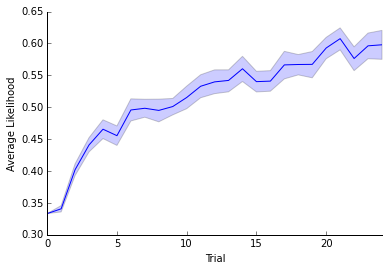

In [49]:
#plot results
sns.tsplot(time = 'trial', value = 'pchoice', unit = 'subj', 
           data = data.groupby(['subj','trial']).mean().reset_index())
sns.despine()
plt.ylabel('Average Likelihood')
plt.xlabel('Trial')
plt.savefig(op.abspath('./rational_rules_prediction.png'),dpi=300)

In [52]:
data.mean()

subj          13.012030
gameNumber    12.502588
trial         11.903555
choice         1.946905
outcome        0.530882
pstim1         0.411624
pstim2         0.399926
pstim3         0.396350
pchoice        0.514050
dtype: float64